In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import classifier_utils, lorentz
from typing import List

In [2]:
save_plots = True
show_titles = False
show_grid = False
black_and_white = True
load_data = False

In [3]:
## Create plots directory, if missing
repo_dir = str(pathlib.Path.home()) + '/physical-background-studies/'

plot_directory = (
    repo_dir + 'plots/'
    + 'armenteros_podolanski/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

# Import MC

In [4]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_lambda = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_b = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_B2JPsiK_Ttracks_v6.h5'

## $\Lambda_b^0 \rightarrow J/\psi\,\Lambda^0$

In [5]:
df_reco = pd.read_hdf(input_lambda, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_lambda, key='LHCbMCTruth_Lb')
df_lambdab = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_lambdab = df_lambdab.loc[(df_lambdab['MC_key'] >= 0) & (df_lambdab['Rec_key'] >= 0)]

df_lambdab['TrackType'] = 'T'

del(df_reco, df_truth)

In [6]:
classifier_utils.calculate_derived_variables(df_lambdab)
df_lambdab = df_lambdab.loc[
    classifier_utils.generate_prefilter(df_lambdab),
    :
].copy()

/home/adegenna/apollo/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
df_lambdab_norm = df_lambdab.loc[df_lambdab['MCTRUTH_L_ID']  == 3122].copy()
df_lambdab_bar = df_lambdab.loc[df_lambdab['MCTRUTH_L_ID']  == -3122].copy()

del(df_lambdab)

## $B^0 \rightarrow J/\psi K_S^0$

In [8]:
df_reco = pd.read_hdf(input_b, key='LHCbMC_B0')
df_truth = pd.read_hdf(input_b, key='LHCbMCTruth_B0')
df_b = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_b = df_b.loc[(df_b['MC_key'] >= 0) & (df_b['Rec_key'] >= 0)]

df_b['TrackType'] = 'T'

del(df_reco, df_truth)

In [9]:
classifier_utils.calculate_derived_variables_B0(df_b)
df_b = df_b.loc[
    classifier_utils.generate_prefilter(df_b, prefilters='B0_PIDSubTemplate'),
    :
].copy()

/home/adegenna/apollo/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


By default, the `PIDSubTemplate` approach always treats the $\pi^+$ as a misconstrued proton, effectively considering the $B^0$ dataset as misconstrued $\Lambda_b^0$. This creates an asymmetry in the Armenteros plots, which treat $\Lambda_b^0$ and $\bar{\Lambda}_b^0$ differently. To obfuscate this, we simply "fake" $\bar{\Lambda}_b^0$ events by taking half of the $B^0$ sample and switching the sign of the pions when computing the momentum asymmetry. Watch and learn, folks.

In [10]:
df_b_norm = df_b.sample(frac=.5, random_state=2022).copy()
df_b_bar = df_b.drop(df_b_norm.index)

del(df_b)

# Import data

In [11]:
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

In [12]:
if load_data:
    df_data = pd.read_hdf(input_data, key='LHCbData')

In [13]:
if load_data:
    classifier_utils.calculate_derived_variables(df_data)
    df_data = df_data.loc[
        classifier_utils.generate_prefilter(df_data),
        :
    ].copy()

In [14]:
if load_data:
    df_data_norm = df_data.loc[df_data['L_ID']  == 3122].copy()
    df_data_bar = df_data.loc[df_data['L_ID']  == -3122].copy()

    del(df_data)

# The Armenteros-Podolanski technique

In [15]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

def norm(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

In [16]:
## Compute variables needed for Armenteros-Podolanski plots
def compute_momentum_asymmetry(
    df: pd.DataFrame, # The DataFrame that will be modified
    mother: str,      # Symbol of the mother: L or KS0
    daughter_1: str,  # Symbol of the conventionally positive daughter
    daughter_2: str,  # Symbol of the conventionally negative daughter
    prefix: str,      # Usually either 'MCTRUTH_' or 'DTF_FixJPsi_'
):

    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}{mother}_P{coord}'] = df[f'{prefix}{daughter_1}_P{coord}'] + df[f'{prefix}{daughter_2}_P{coord}']

    mother_uv = lorentz.unit_vector(np.array([df[f'{prefix}{mother}_PX'], df[f'{prefix}{mother}_PY'], df[f'{prefix}{mother}_PZ']]))
    part1_p = np.array([df[f'{prefix}{daughter_1}_PX'], df[f'{prefix}{daughter_1}_PY'], df[f'{prefix}{daughter_1}_PZ']])
    part2_p = np.array([df[f'{prefix}{daughter_2}_PX'], df[f'{prefix}{daughter_2}_PY'], df[f'{prefix}{daughter_2}_PZ']])

    part1_pL = scalar_product(part1_p, mother_uv)
    part2_pL = scalar_product(part2_p, mother_uv)

    part1_pT = part1_p - part1_pL * mother_uv
    part2_pT = part2_p - part2_pL * mother_uv

    part1_pT_norm = norm(part1_pT)
    part2_pT_norm = norm(part2_pT)

    df[f'{prefix}pL1'] = part1_pL
    df[f'{prefix}pL2'] = part2_pL
    df[f'{prefix}pT1'] = part1_pT_norm
    df[f'{prefix}pT2'] = part2_pT_norm
    
    df[f'{prefix}p_asymm'] = (df[f'{prefix}pL1'] - df[f'{prefix}pL2'])/(df[f'{prefix}pL1'] + df[f'{prefix}pL2'])

## Monte Carlo

In [17]:
def armenteros_podolanski_plot_mc(prefix):
    df_lambdab = pd.concat([df_lambdab_norm, df_lambdab_bar])
    df_b = pd.concat([df_b_norm, df_b_bar])
    
    if black_and_white:
        lb_color = 'black'
        b_color = 'tab:gray'
    else:
        lb_color = 'tab:blue'
        b_color = 'tab:orange'
    
    plt.scatter(
        df_lambdab[f'{prefix}p_asymm'], df_lambdab[f'{prefix}pT1'],
        marker='.',
        s=2,
        label=r'$\Lambda^0 \rightarrow p \pi^-$',
        color=lb_color,
        rasterized=True
    )

    plt.scatter(
        df_b[f'{prefix}p_asymm'], df_b[f'{prefix}pT1'],
        marker='.',
        s=2,
        label=r'$K_S^0 \rightarrow \pi^+ \pi^-$',
        color=b_color,
        rasterized=True
    )

    plt.xlabel(r"$(p_L^+ - p_L^-)/(p_L^+ + p_L^-)$")
    plt.ylabel(r"$p_T$ [MeV/$c$]")

    plt.xlim(-1,1)
    plt.ylim(-10,300)
    
    lgnd = plt.legend(frameon=False)
    dot_size_legend = 100
    lgnd.legendHandles[0]._sizes = [dot_size_legend]
    lgnd.legendHandles[1]._sizes = [dot_size_legend]
    
    if save_plots:
        plt.savefig(plot_directory + f'{prefix}armenteros_podolanski_MC_scatter.pdf', bbox_inches='tight', dpi=150)

    plt.show()    

In [18]:
def armenteros_podolanski_hist2d_mc(prefix, upper_clims: List[int] = None):
    df_lambdab = pd.concat([df_lambdab_norm, df_lambdab_bar])
    df_b = pd.concat([df_b_norm, df_b_bar])
    
    if black_and_white:
        cmap = 'binary_r'
    else:
        cmap = 'turbo'
    
    plt.hist2d(
        df_lambdab[f'{prefix}p_asymm'],
        df_lambdab[f'{prefix}pT1'],
        range=[[-1,1],[0,300]], bins=200,
        cmap=cmap
    )
    
    plt.colorbar(label='Events')
    
    if upper_clims is not None:
        plt.clim(0, upper_clims[0])
    
    plt.xlabel(r"$(p_L^+ - p_L^-)/(p_L^+ + p_L^-)$")
    plt.ylabel(r"$p_T$ [MeV/$c$]")
    
    if save_plots:
        plt.savefig(plot_directory + f'{prefix}armenteros_podolanski_MC_hist2d_Lb.pdf', bbox_inches='tight')
    
    plt.show()

    ####################################################
    
    plt.hist2d(
        df_b[f'{prefix}p_asymm'],
        df_b[f'{prefix}pT1'],
        range=[[-1,1],[0,300]], bins=200,
        cmap=cmap
    )
    
    plt.xlabel(r"$(p_L^+ - p_L^-)/(p_L^+ + p_L^-)$")
    plt.ylabel(r"$p_T$ [MeV/$c$]")
    
    plt.colorbar(label='Events')
    
    if upper_clims is not None:
        plt.clim(0, upper_clims[1])
        
    if save_plots:
        plt.savefig(plot_directory + f'{prefix}armenteros_podolanski_MC_hist2d_B0.pdf', bbox_inches='tight')
    
    plt.show()

### True momenta

In [19]:
compute_momentum_asymmetry(df_lambdab_norm, 'L', 'p', 'pim', 'MCTRUTH_')
compute_momentum_asymmetry(df_lambdab_bar, 'L', 'pim', 'p', 'MCTRUTH_')
compute_momentum_asymmetry(df_b_norm, 'KS0', 'pip', 'pim', 'MCTRUTH_')
compute_momentum_asymmetry(df_b_bar, 'KS0', 'pim', 'pip', 'MCTRUTH_')

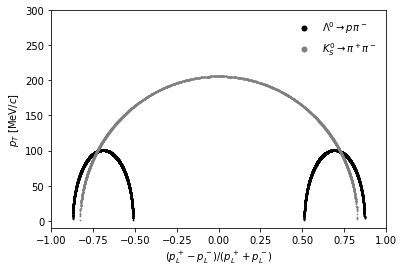

In [20]:
armenteros_podolanski_plot_mc('MCTRUTH_')

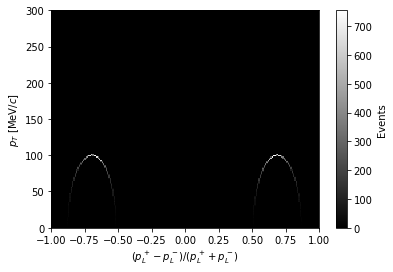

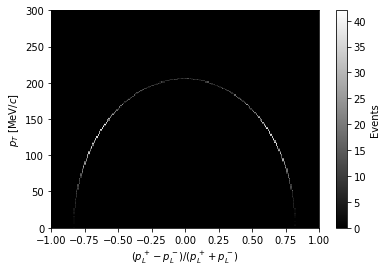

In [21]:
armenteros_podolanski_hist2d_mc('MCTRUTH_')

### DTF momenta ($J/\psi$ mass constraint)

In [22]:
compute_momentum_asymmetry(df_lambdab_norm, 'L', 'p', 'pim', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_lambdab_bar, 'L', 'pim', 'p', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_b_norm, 'KS0', 'pip', 'pim', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_b_bar, 'KS0', 'pim', 'pip', 'DTF_FixJPsi_')

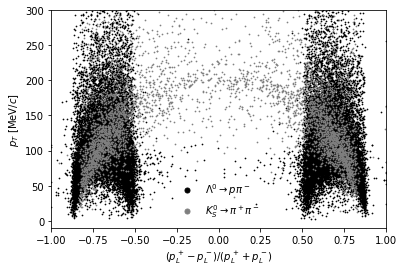

In [23]:
armenteros_podolanski_plot_mc('DTF_FixJPsi_')

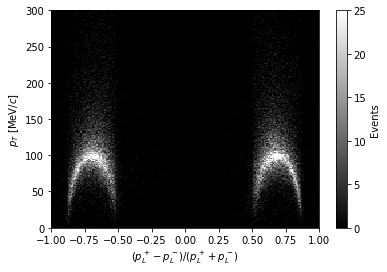

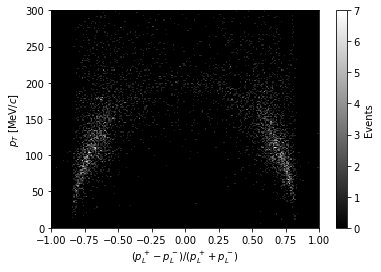

In [24]:
armenteros_podolanski_hist2d_mc('DTF_FixJPsi_', upper_clims=[25,7])

## Run 2 data

In [25]:
def armenteros_podolanski_plot_data(prefix):
    df_data = pd.concat([df_data_norm, df_data_bar])
    
    if black_and_white:
        color = 'black'
    else:
        color = 'tab:blue'
    
    plt.scatter(
        df_data[f'{prefix}p_asymm'], df_data[f'{prefix}pT1'],
        marker='.',
        s=2,
        label=r'$\Lambda^0 \rightarrow p \pi^-$',
        color=color,
        rasterized=True
    )

    plt.xlabel(r"$(p_L^+ - p_L^-)/(p_L^+ + p_L^-)$")
    plt.ylabel(r"$p_T$ [MeV/$c$]")

    plt.xlim(-1,1)
    plt.ylim(-10,300)
    
    if save_plots:
        plt.savefig(plot_directory + f'{prefix}armenteros_podolanski_Data_scatter.pdf', bbox_inches='tight', dpi=150)

    plt.show()    

In [26]:
def armenteros_podolanski_hist2d_data(prefix, upper_clim: int = None):
    df_data = pd.concat([df_data_norm, df_data_bar])
    
    if black_and_white:
        cmap = 'binary_r'
    else:
        cmap = 'turbo'
    
    plt.hist2d(
        df_data[f'{prefix}p_asymm'],
        df_data[f'{prefix}pT1'],
        range=[[-1,1],[0,300]], bins=200,
        cmap=cmap
    )
    
    plt.colorbar(label='Events')
    
    if upper_clim is not None:
        plt.clim(0, upper_clim)
    
    plt.xlabel(r"$(p_L^+ - p_L^-)/(p_L^+ + p_L^-)$")
    plt.ylabel(r"$p_T$ [MeV/$c$]")
    
    if save_plots:
        plt.savefig(plot_directory + f'{prefix}armenteros_podolanski_Data_hist2d.pdf', bbox_inches='tight')
    
    plt.show()

In [27]:
if load_data:
    compute_momentum_asymmetry(df_data_norm, 'L', 'p', 'pim', 'DTF_FixJPsi_')
    compute_momentum_asymmetry(df_data_bar, 'L', 'pim', 'p', 'DTF_FixJPsi_')

In [28]:
#armenteros_podolanski_plot_data('DTF_FixJPsi_')

In [29]:
if load_data:
    if black_and_white:
        upper_clim = 600
    else:
        upper_clim = None

    armenteros_podolanski_hist2d_data('DTF_FixJPsi_', upper_clim=upper_clim)

# Efficiency of cut
We use a symmetric $|p_{asym}| > p_{thres}$ cut.

In [30]:
df_lambdab = pd.concat([df_lambdab_norm, df_lambdab_bar])
df_b = pd.concat([df_b_norm, df_b_bar])

In [31]:
current_veto = 0.5

In [32]:
tot_evts_lambdab = len(df_lambdab)
tot_events_b = len(df_b)

In [33]:
def compute_lambdab_efficiency(threshold):
    selection = abs(df_lambdab['DTF_FixJPsi_p_asymm']) > threshold
    ## Selection is what we keep
    return sum(selection)/tot_evts_lambdab

def compute_b_efficiency(threshold):
    selection = abs(df_b['DTF_FixJPsi_p_asymm']) > threshold
    return sum(selection)/tot_events_b

In [34]:
thresholds = np.linspace(0,1,51)
lambdab_sig_eff = np.array([compute_lambdab_efficiency(threshold) for threshold in thresholds])
b_sig_eff = np.array([compute_b_efficiency(threshold) for threshold in thresholds])

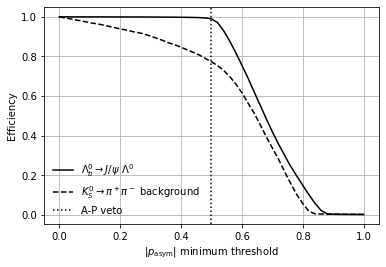

In [41]:
filename = 'ap_efficiencies'

common_params = {
    'color': 'black'
}

lambda_params = {
    'linestyle': '-',
    'label': r'$\Lambda_b^0 \rightarrow J/\psi~\Lambda^0$'
}

b_params = {
    'linestyle': '--',
    'label': r'$K^0_S \rightarrow \pi^+\pi^-$ background'
}

axv_params = {
    'linestyle': 'dotted',
    'label': 'A-P veto'
}

plt.plot(thresholds, lambdab_sig_eff, **common_params, **lambda_params)
plt.plot(thresholds, b_sig_eff, **common_params, **b_params)
plt.axvline(current_veto, **common_params, **axv_params)
plt.xlabel(r"$|p_\mathrm{asym}|$ minimum threshold")
plt.ylabel("Efficiency")
plt.legend(frameon=False)
plt.grid()

if save_plots:
    plt.savefig(plot_directory + filename + '.pdf', bbox_inches='tight')

plt.show()

In [36]:
def compute_signal_significance(threshold):
    s = compute_lambdab_efficiency(threshold)
    b = compute_b_efficiency(threshold)
    
    return s/np.sqrt(s+b)

def compute_signal_purity(threshold):
    s = compute_lambdab_efficiency(threshold)
    b = compute_b_efficiency(threshold)
    
    return s/(s+b)

In [37]:
sig_significances = np.array([compute_signal_significance(threshold) for threshold in thresholds])
sig_purities = np.array([compute_signal_purity(threshold) for threshold in thresholds])

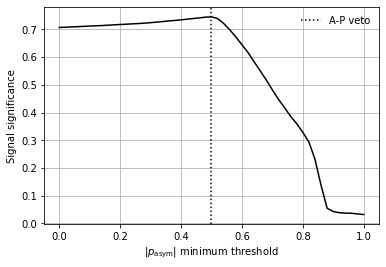

In [42]:
filename = 'ap_significances'

plt.plot(thresholds, sig_significances, color='black')
plt.axvline(current_veto, **common_params, **axv_params)

plt.xlabel(r"$|p_\mathrm{asym}|$ minimum threshold")
plt.ylabel("Signal significance")
plt.grid()
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + filename + '.pdf', bbox_inches='tight')
plt.show()

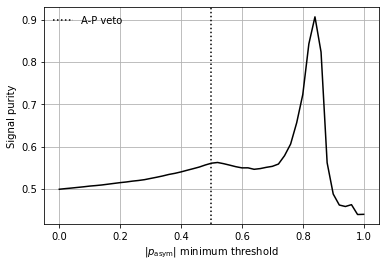

In [43]:
filename = 'ap_purities'

plt.plot(thresholds, sig_purities, color='black')
plt.axvline(current_veto, **common_params, **axv_params)
plt.xlabel(r"$|p_\mathrm{asym}|$ minimum threshold")
plt.ylabel("Signal purity")
plt.grid()
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + filename + '.pdf', bbox_inches='tight')
plt.show()

In [40]:
for t, s, b, ss, sp in zip(thresholds, lambdab_sig_eff, b_sig_eff, sig_significances, sig_purities):
    print(f'{t}\t\t{s}\t{1-b}\t{ss}\t{sp}')

0.0		1.0	0.0	0.7071067811865475	0.5
0.02		0.9999764417640407	0.005915992900808464	0.7081424168725012	0.501477496499218
0.04		0.9999057670561629	0.011240386511536138	0.7090522124816087	0.5028024205773237
0.06		0.9998822088202035	0.017156379412344713	0.710096723565097	0.5042967585280403
0.08		0.9998822088202035	0.022875172549792988	0.7111230132406348	0.5057555134990637
0.1		0.9997879758763664	0.029579964504042544	0.712281835186578	0.5074530050154331
0.12		0.9997644176404071	0.03431275882468943	0.7131263641312299	0.5086690446728234
0.14		0.9997173011684886	0.0398343521987774	0.7141051100149528	0.510090310084094
0.16		0.9996466264606106	0.04693354367974756	0.7153643390035979	0.5119270389877306
0.18		0.9995995099886921	0.054032735160717826	0.7166431664906386	0.5137831931145493
0.2		0.9995288352808142	0.060934726878327794	0.7178800481572404	0.5155946935712519
0.22		0.9994581605729363	0.06665352001577596	0.7189035670930377	0.5171025253151438
0.24		0.9993639276290991	0.07414711102346672	0.7202